 [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started). 

![nlp-getting-started image](https://storage.googleapis.com/kaggle-media/competitions/nlp1-cover.jpg)


Our goal here to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

What's in the notebook?

    Exploratory Data Analysis (EDA)
    Text Prosessing & Data Cleaning
    Evaluation

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


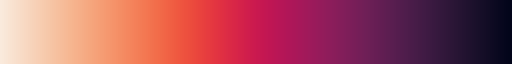

In [83]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

import os
import re
import tqdm.notebook as tqdm

# sklearn
import sklearn

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, RepeatedStratifiedKFold, KFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
# xgboost
from xgboost import XGBClassifier, XGBRFClassifier
# keras
import tensorflow as tf
# nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
# transformers
from transformers import AutoTokenizer,TFBertModel
# packages need to be downloaded
!pip install pyspellchecker;
from spellchecker import SpellChecker

# settings
plt.style.use('ggplot')
get_ipython().run_line_magic('matplotlib', 'inline') #ensure in-line plotting
stop = set(stopwords.words('english'))
sns.color_palette("rocket_r", as_cmap=True)

In [84]:
df = pd.read_csv('../input/nlp-getting-started/train.csv', index_col=0)
df_test = pd.read_csv('../input/nlp-getting-started/test.csv', index_col=0)
submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv", index_col=0)
df

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


## Data analysis

In the following we're going to see some data analysis on the corpus.

Specifically:

    General dataset infos
        Number of samples
        Data Columns
        Class Label Distributiom

    Text analysis
        Top words in positive & negative tweets
        Hashtag Analysis
        The word cloud

In [ ]:
print(f"Number of train samples {df.shape[0]}")
print(f"Number of test samples {df_test.shape[0]}")

In [85]:
N = np.random.randint(0, df.shape[0])

In [86]:
df.isnull().sum(axis=0)

keyword       61
location    2533
text           0
target         0
dtype: int64

### Class Label Distributiom

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


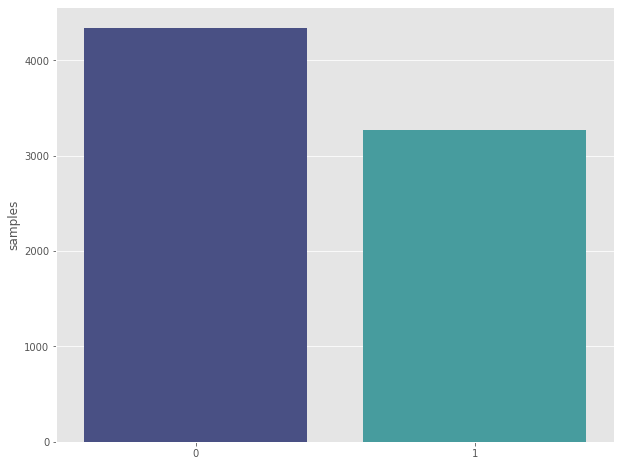

In [87]:
n = df.target.value_counts();
plt.figure(figsize=(10, 8));
sns.barplot(n.index, n, palette="mako").set_ylabel('samples');

<Figure size 864x720 with 0 Axes>

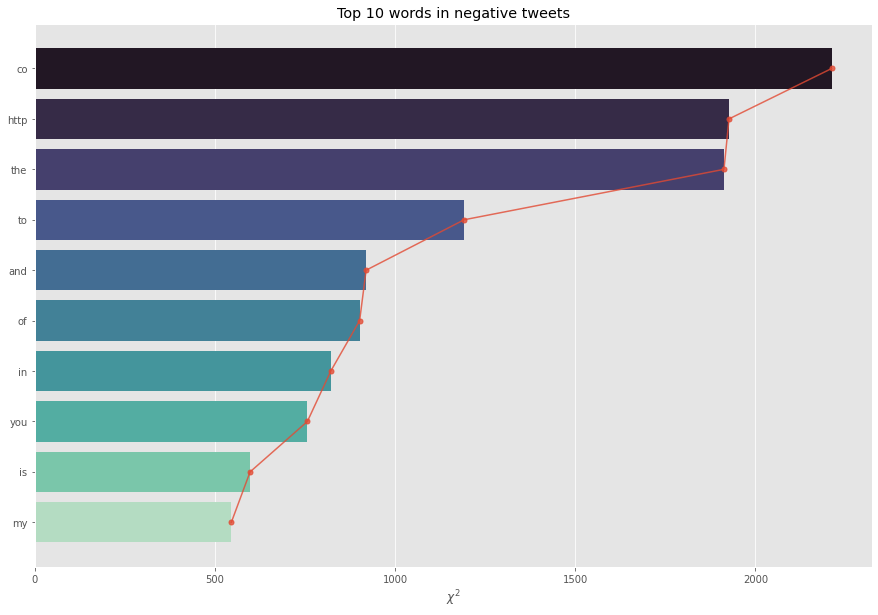

<Figure size 864x720 with 0 Axes>

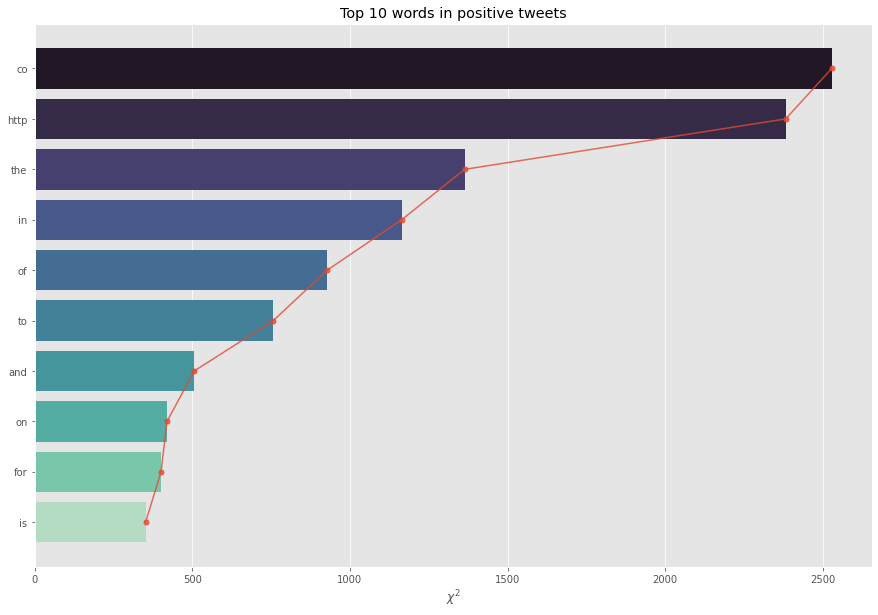

In [88]:
def get_top_tweet_bigrams(df, column_name='text', target=1, n=None):
    txt = df[df['target']==target][column_name].str.lower()
    vec = CountVectorizer(ngram_range=(1, 1)).fit(txt)
    bag_of_words = vec.transform(txt)
    sum_words = bag_of_words.sum(axis=0) 
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def visuaize_top10(top, title=''):
    plt.figure(figsize=(12,10))
    x, y = map( list, zip(*top) )
    n = np.arange(len(x))
    
    plt.figure(figsize=(15,10))
    #plt.barh(x, y, align='center', alpha=0.2)
    sns.barplot(x=y, y=x, palette="mako");
    plt.plot(y, n, '-o', markersize=5, alpha=0.8)
    plt.yticks(n, x);
    plt.xlabel('$\chi^2$');
    plt.title(title)
    
visuaize_top10(get_top_tweet_bigrams(df, 'text', 0, n=10), 'Top 10 words in negative tweets')
visuaize_top10(get_top_tweet_bigrams(df, 'text', 1, n=10), 'Top 10 words in positive tweets')

### Hashtag Analysis

-Number of tweets with hashtags: 7613


<Figure size 864x720 with 0 Axes>

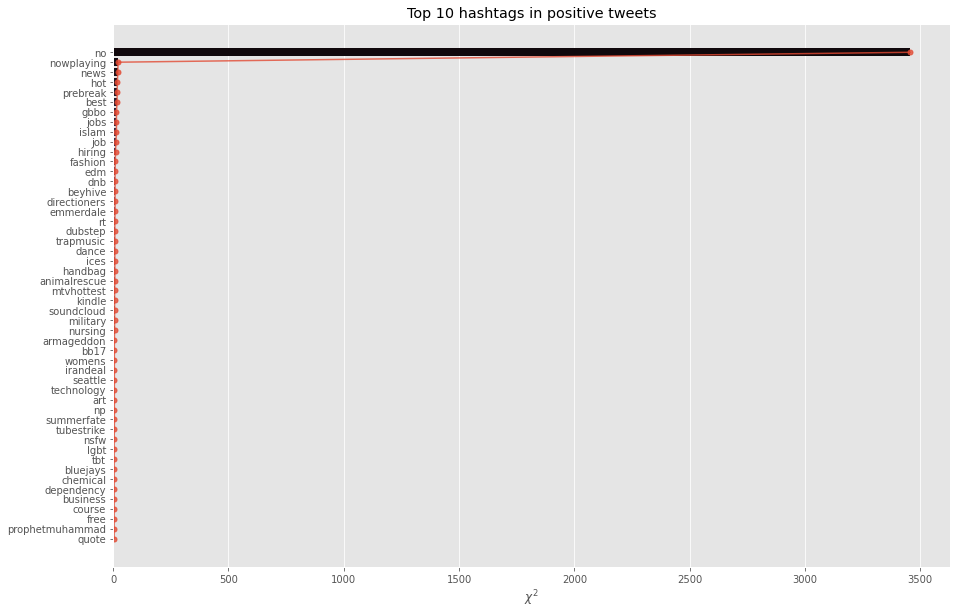

<Figure size 864x720 with 0 Axes>

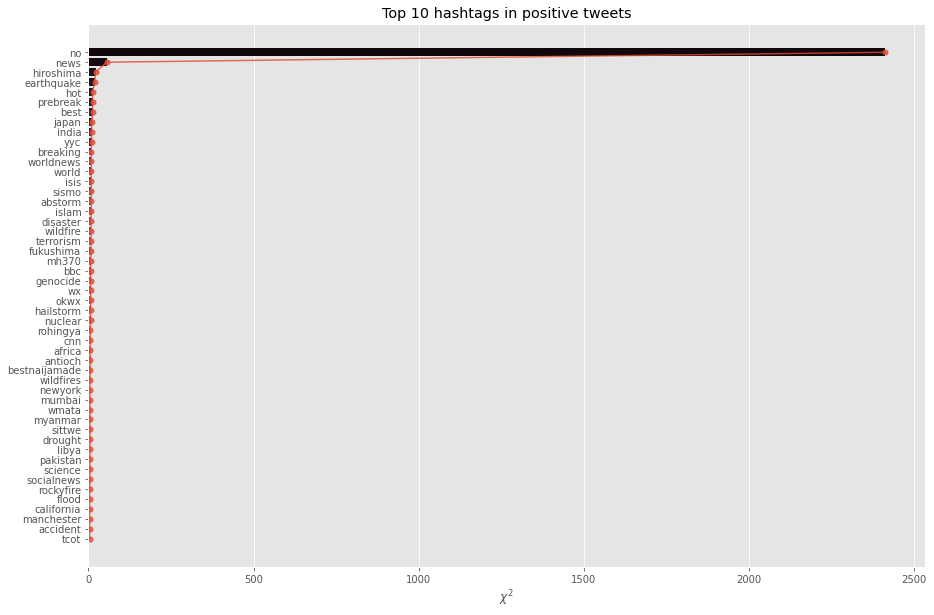

In [89]:
def find_hashtags(tweet):
    return ", ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or None

def add_hashtags(df):
    df['hashtag'] = df["text"].apply(lambda x: find_hashtags(x))
    df['hashtag'].fillna(value="no", inplace=True)
    return df
    

hashtags_df = add_hashtags(df)
_l = len([v for v in df.hashtag.values if isinstance(v, str)])
print(f"-Number of tweets with hashtags: {_l}")

visuaize_top10(
    get_top_tweet_bigrams(hashtags_df, 'hashtag', 0, n=50),
    'Top 10 hashtags in positive tweets'
)

visuaize_top10(
    get_top_tweet_bigrams(hashtags_df, 'hashtag', 1, n=50),
    'Top 10 hashtags in positive tweets'
)

There is too much intersection between hashtag in positive and negative samples, meaning that an
#hashtag approach will not work that well.

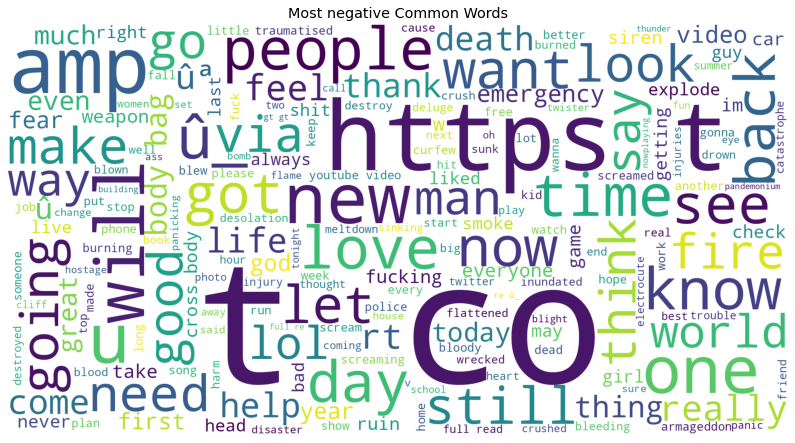

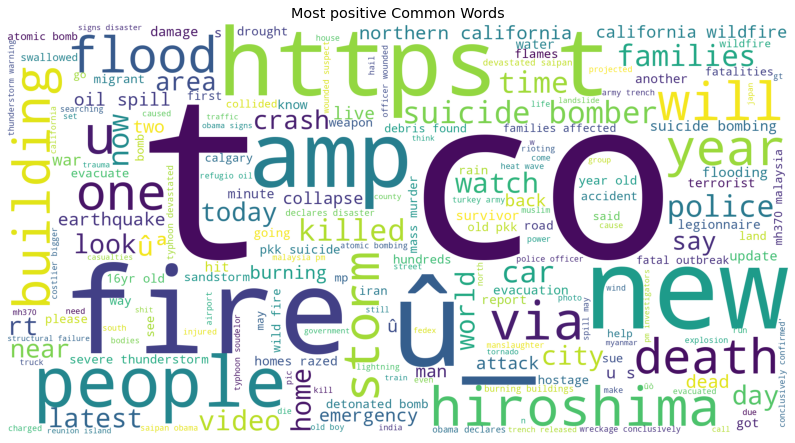

In [90]:
def word_cloud(df, target):
    targets = {
        0: 'negative',
        1: 'positive',
    }
    #create instance of the WordCloud() 
    word_cloud=WordCloud(height=1080, width=2048, background_color='white')

    #get the text in a big string
    txt = df.text[df['target']==target].str.lower()
    text=" ".join([str(word) for word in txt])

    #generate the word cloud
    word_cloud.generate(text)

    #display now
    plt.figure(figsize=(14, 12));
    plt.imshow(word_cloud);
    plt.axis("off");
    plt.title(f"Most {targets[target]} Common Words");
    
word_cloud(df, target=0)
word_cloud(df, target=1)

## Text Processing and Data Cleaning
Here we clean our dataset. Specifically, we clean:

    URLs
    HTMLs
    punctuations
    whitespaces
    stopwords
    
and apply following ideas:

    convert text to lower
    replace emoji and smileys by their corresponding text
    Chatwords conversion
    correct spellings
    lemmatizing
    stemming

### Remove URL

In [91]:
def remove_url(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

remove_url(df.text[120])

"#TruckCrash Overturns On #FortWorth Interstate  Click here if you've been in a crash&gt;"

### Remove HTML

In [92]:
example = """<div>
<h1>head</h1>
<p>paragraph</p>
<a href="https://www.kaggle.com/">url</a>
</div>"""

def remove_html(text):
    html_pattern = re.compile(r'<.*?>')
    return html_pattern.sub(r'', text)

remove_html(example)

'\nhead\nparagraph\nurl\n'

### Replace emoji and smileys by their corresponding text
Here we scrap emoticons and their corresponding text using BeautifulSoup from [emoticonr](https://www.emoticonr.com/emoticons)

In [93]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

url = "https://www.emoticonr.com/emoticons"  # change to whatever your url is

page = urlopen(url).read()
soup = BeautifulSoup(page)

smileys = {}
for div in soup.find_all("div", {"class": "tableText"}):
    divs = div.find_all("div")
    smileys[divs[1].text] = divs[0].text
    
#
smileys_df = pd.DataFrame(
    smileys.items(), 
    columns = ['smiley', 'meaning'],
    index=np.arange(len(smileys))
)
smileys_df

,smiley,meaning
0,>-),Alien
1,O:),Angel
2,O:-),Angel
3,X(,Angry or Grumpy
4,>:-(,Angry or Grumpy
...,...,...
149,;-),Winking
150,:-S,Worried
151,(:|,Yawn
152,>:O,Yelling


In [94]:
import emoji

def replace_emoji(text):
    #replace emojis by their corresponding text
    text = emoji.demojize(text, delimiters=("", ""))
    #replace smileys by their corresponding text
    new_text = ""
    for w in text.split():
        if w.upper() in smileys:
            new_text = new_text + smileys_df.meaning[smileys_df.smiley==w.upper()].values[0] + " "
        else:
            new_text = new_text + w + " "
    return new_text

text = "game is on 🔥 :-) 😀 :|  "

print(text) # with emoji
print(replace_emoji(text))

game is on 🔥 :-) 😀 :|  
game is on fire  Smile or happy face grinning_face  Straight face 


### Remove punctuation

In [95]:
def remove_punc(text):
    # remove '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    return re.sub(r'[^\w\s]', '', text)
     

text = "Gfg, is best : for ! Geeks ;"
remove_punc(text)

'Gfg is best  for  Geeks '

### Remove whitespace from text

In [96]:
# remove whitespace from text
def remove_whitespace(text):
    return  " ".join(text.split())

remove_whitespace("   abc abc ab c  ")

'abc abc ab c'

### Remove Non-ASCI

In [97]:
def remove_non_ascii(text):
    """
        Remove non-ASCII characters 
    """
    return re.sub(r'[^\x00-\x7f]',r'', text)
    #return ''.join([x for x in text if x in string.printable]) 
remove_non_ascii('Ǹ text Ǹ')

' text '

### Chatwords conversion
Here we scrap chatwords and their meanings using BeautifulSoup from [englishclub](https://www.englishclub.com/esl-chat/abbreviations.htm)

In [98]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

url = "https://www.englishclub.com/esl-chat/abbreviations.htm"  # change to whatever your url is

page = urlopen(url).read()
soup = BeautifulSoup(page)
len(soup.find_all('table'))

chatwords = {}
soup.find_all('table')[1]
for table in soup.find_all('table'):
    for tr in table.find_all('tr'):
        tds = tr.find_all('td')
        chatwords[tds[0].text.upper()] = tds[1].text
        
chatwords_df = pd.DataFrame(
    chatwords.items(), 
    columns = ['abbreviation', 'meaning'],
    index=np.arange(len(chatwords))
)
chatwords_df

,abbreviation,meaning
0,?4U,I have a question for you.
1,^^,Read line above
2,<3,love
3,2,to
4,2MRW,tomorrow
...,...,...
71,W/,with
72,W/O,without
73,WRU,Where are you?
74,XO,hugs and kisses / love


In [99]:
# Chatwords conversion
def convert_chat_words(text):
    new_text = ""
    for w in text.split():
        if w.upper() in chatwords:
            new_text = new_text + chatwords_df.meaning[chatwords_df.abbreviation==w.upper()].values[0] + " "
        else:
            new_text = new_text + w + " "
    return new_text

convert_chat_words("one minute BRB")

'one minute Be right back '

### Correct Spellings

In [100]:
def correct_spellings(text):
    spell = SpellChecker()
    # find words that may be misspelled
    misspelled_words = spell.unknown(text.split())
    # a list of `likely` options
    corrected_text = []
    
    for word in text.split():
        if word in misspelled_words:
            # Get the one `most likely` answer
            correct = spell.correction(word)
            corrected_text.append(correct)
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese"
correct_spellings(text)

'correct me plese'

### word tokenizer
- remove non alpha 
- remove stopwords (such as “the”, “a”, “an”, “in”)

In [101]:
def word_tokenizer(text):
    """
    word tokenize
    remove non alpha 
    remove stopwords (such as “the”, “a”, “an”, “in”)
    """
    words = [word for word in word_tokenize(text) if((word not in stop)&(word.isalpha())&(len(word)>1))]
    #words = [word for word in word_tokenize(text) if((word.isalpha())&(len(word)>1))]
    return ' '.join(words)

word_tokenizer(df.text.iloc[N])

'Finnish nuclear plant move ahead financing secured http via business'

# Lemmatisation and stemming

Lemmatisation is closely related to stemming. The difference is that a stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech. However, stemmers are typically easier to implement and run faster, and the reduced accuracy may not matter for some applications.

    For instance:

        The word "better" has "good" as its lemma. This link is missed by stemming, as it requires a dictionary look-up.

        The word "walk" is the base form for word "walking", and hence this is matched in both stemming and lemmatisation.

        The word "meeting" can be either the base form of a noun or a form of a verb ("to meet") depending on the context, e.g., "in our last meeting" or "We are meeting again tomorrow". Unlike stemming, lemmatisation can in principle select the appropriate lemma depending on the context.



In [102]:
def do_stemming(text):
    #Create instance of a PorterStemmer
    #stemmer = PorterStemmer()
    stemmer = SnowballStemmer(language='english')
    new_str = ""
    for word in text.split():
        tokenizer = word_tokenizer(word)
        new_str = new_str + stemmer.stem(tokenizer) + " "
    return new_str

print(df.text.iloc[N])
print(do_stemming(df.text.iloc[N]))

Finnish nuclear plant to move ahead after financing secured http://t.co/D8aWX2okKe via @business
finnish nuclear plant  move ahead  financ secur http via busi 


In [103]:
def do_lemmatizing(text):
    #Create instance of a PorterStemmer
    lemmatizer = WordNetLemmatizer()
    new_str = ""
    for word in text.split():
        tokenizer = word_tokenizer(word)
        new_str = new_str + lemmatizer.lemmatize(tokenizer) + " "
    return new_str

print(df.text.iloc[N])
print(do_lemmatizing(df.text.iloc[N]))

Finnish nuclear plant to move ahead after financing secured http://t.co/D8aWX2okKe via @business
Finnish nuclear plant  move ahead  financing secured http via business 


In [104]:
def clean_text(df, df_test, normalize='lemmatize'):
    X = pd.concat([df, df_test])
    
    X.text = X.text.str.lower()
    X.text = X.text.apply(lambda text: remove_url(text))
    X.text = X.text.apply(lambda text: remove_html(text))
    X.text = X.text.apply(lambda text: remove_non_ascii(text))
    X.text = X.text.apply(lambda text: replace_emoji(text))
    X.text = X.text.apply(lambda text: remove_punc(text))
    X.text = X.text.apply(lambda text: convert_chat_words(text))
    X.text = X.text.apply(lambda text: remove_whitespace(text))
    #X.text = X.text.apply(lambda text: correct_spellings(text))  
    if normalize == 'lemmatize':
        X.text = X.text.apply(lambda text: do_lemmatizing(text))
    if normalize == 'stem':
        X.text = X.text.apply(lambda text: do_stemming(text))
    
    X_test = X.loc[df_test.index, :]
    X.drop(X_test.index, inplace=True)
    return X, X_test
    
new_df, new_df_test = clean_text(df, df_test)
df.text.iloc[0], new_df.text.iloc[0]

('Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 ' deed   reason   earthquake may allah forgive u  ')

In [105]:
new_df.text.isnull().sum(), new_df_test.text.isnull().sum()

(0, 0)

<Figure size 864x720 with 0 Axes>

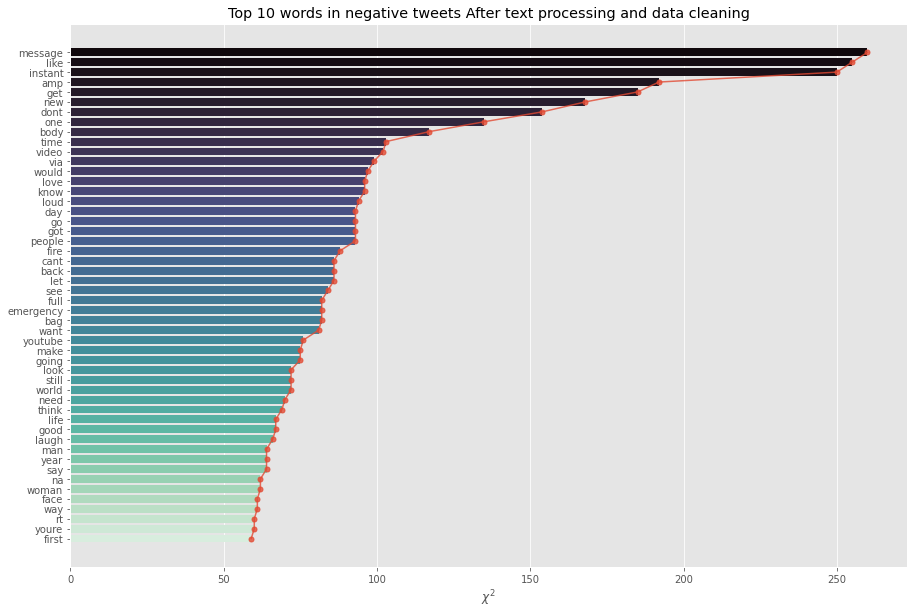

<Figure size 864x720 with 0 Axes>

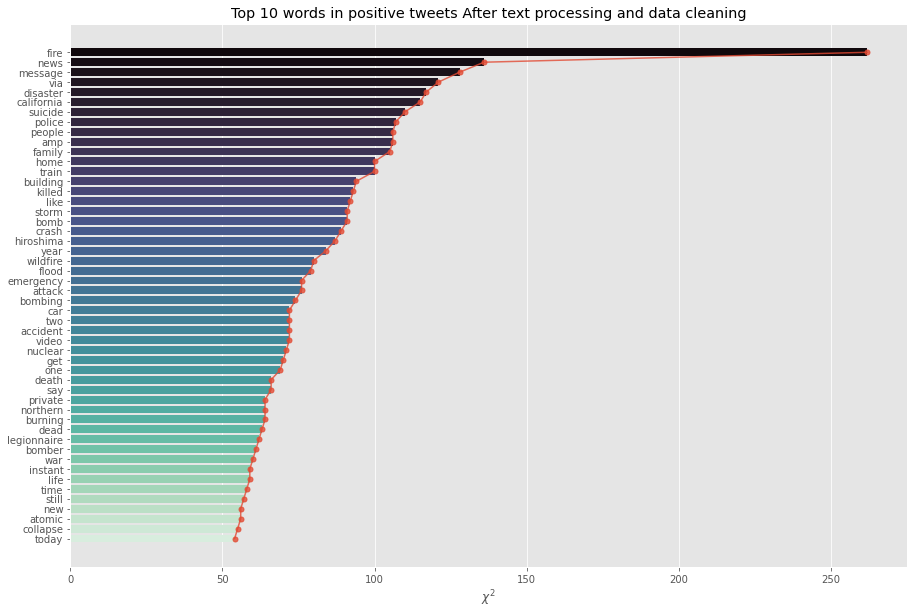

In [106]:
visuaize_top10(get_top_tweet_bigrams(new_df, 'text', 0, n=50), 'Top 10 words in negative tweets After text processing and data cleaning')
visuaize_top10(get_top_tweet_bigrams(new_df, 'text', 1, n=50), 'Top 10 words in positive tweets After text processing and data cleaning')

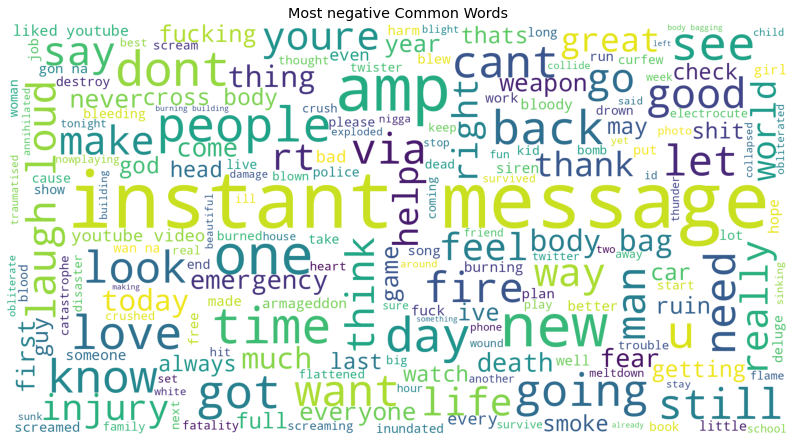

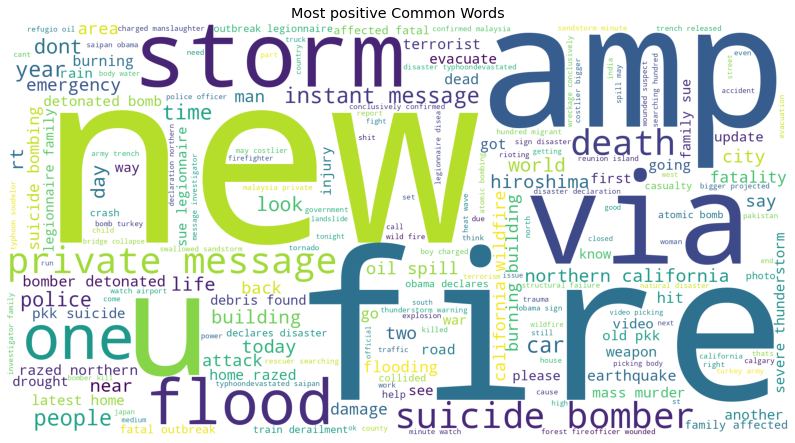

In [107]:
word_cloud(new_df, target=0)
word_cloud(new_df, target=1)

### Chi2 Feature Selection
    
In Scikit-learn library, there are three methods you can use for feature selection with sparse matrices such as Tfidf vectors or count vectors. By looking at the documentation, you can see that chi2, mutual_info_regression, mutual_info_classif will deal with the data without making it dense. In my case, I have 1.5 million tweets and want to reduce dimensions from 100,000 features, thus transform this into dense matrices is not an option. It will not fit into my RAM.

    The chi-squared statistic measures the lack of independence between a feature (in this case, one term within a tweet) and class (whether the tweets are positive or negative).

In [108]:
tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 1))
x_tfidf = tvec.fit_transform(new_df.text)
chi2score = chi2(x_tfidf, new_df.target)[0]
topchi2 = zip(tvec.get_feature_names(), chi2score)
chi2_df = pd.DataFrame(topchi2, columns=['feature', 'chi2']).sort_values(by='chi2', ascending=False)[:20]
chi2_df.reset_index(inplace=True, drop=True)
chi2_df

,feature,chi2
0,california,37.566576
1,hiroshima,32.341780
2,wildfire,30.351140
3,suicide,29.470502
4,fire,28.622776
5,killed,27.758953
6,northern,26.320634
7,bombing,25.475425
8,legionnaire,23.890604
9,train,22.491849


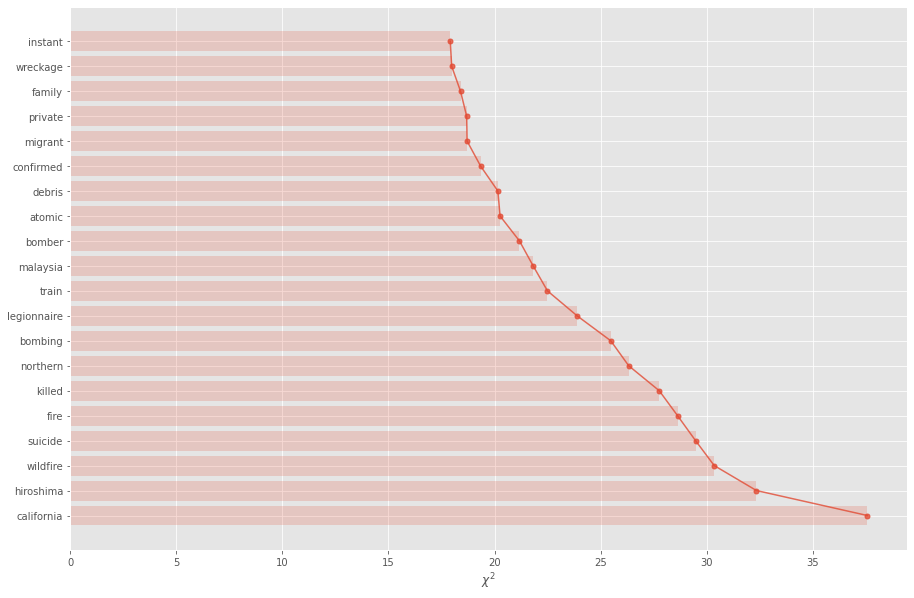

In [109]:
plt.figure(figsize=(15,10))
plt.barh(chi2_df.feature, chi2_df.chi2, align='center', alpha=0.2)
plt.plot(chi2_df.chi2, chi2_df.index, '-o', markersize=5, alpha=0.8)
plt.yticks(chi2_df.index, chi2_df.feature);
plt.xlabel('$\chi^2$');

![](https://miro.medium.com/max/900/1*3-KkZ0hlRZxjMn7Z6uXDGg.png)

### Evaluation:

    tfidf & Classic ml classifiers like SVC, LogisticRegression...
    Simple LSTM Model
    Glove Bi-LSTM
    BERT
    
 TF-IDF:
 
     - a numerical statistic that reflect how important a word is to a document in a collection or corpus.
     - TfidfVectorizer equivalent to CountVectorizer followed by TfidfTransformer.

    Select KBest — This is used to select the top k features from the sorted feature importance’s sorted in decreasing order.
    
    SelectFromModel — This is used to select the feature importance’s from a model so that they can be used to train another model.

In [110]:
X = new_df.text
X_test = new_df_test.text
y = np.array(new_df.target).reshape((-1,1)).ravel()

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [111]:
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
#cv = KFold(n_splits=5)

In [112]:
def gridsearch_model(model, parameters, X, y, X_test):
    grid = GridSearchCV(model, parameters, cv=cv, refit=True, n_jobs=-1, verbose=1)
    grid.fit(X, y.ravel())
    # print best parameter after tuning
    print(grid.best_params_)
    # print how our model looks after hyper-parameter tuning
    print(grid.best_estimator_)

# evaluate a given model using cross-validation
def evaluate_model(model, X, y, X_test=X_test):
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    print(f"Score {type(model.named_steps['clf']).__name__} is {scores.mean():.2f}")
    #print(f"Score is {scores.mean():.2f}")

def my_pipeline(clf):
    return Pipeline([
        #('tfid', TfidfVectorizer()),
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('skb', SelectKBest(chi2, k = 13000)),
        #('lsvc', SelectFromModel(LogisticRegression())),
        ('clf', clf),
    ])

def Save_Submit(model): 
    predict = model.fit(X, y).predict(X_test)
    submission.target = predict.astype(int)
    submission.to_csv(f"{type(model.named_steps['clf']).__name__}_submit.csv")
    print("Saved!")

In [113]:
############################# SVC #######################################
svc_clf = my_pipeline(clf=SVC())
svc_param_grid = {
    'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
    'clf__C': [0.1, 1, 10, 100, 1000],
    'clf__gamma':  [1, 0.1, 0.01, 0.001, 0.0001],
}
#gridsearch_model(svc_clf, svc_param_grid, X, y, X_test)
######################## LogisticRegression #############################
log_clf = my_pipeline(clf=LogisticRegression())
log_param_grid = {
    'clf__C': [0.001, 0.01, 0.05, 0.1, 0,5, 1]
}
#gridsearch_model(log_clf, log_param_grid, X, y, X_test)

In [114]:
############################# SVC #######################################
svc_best_params = {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
svc_clf = my_pipeline(SVC(**svc_best_params))
evaluate_model(svc_clf, X, y)
#Save_Submit(svc_clf)
######################## LogisticRegression #############################
log_best_params = {'C': 1}
log_clf = my_pipeline(LogisticRegression(**log_best_params))
evaluate_model(log_clf, X, y)
#Save_Submit(log_clf)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Score SVC is 0.81
Score LogisticRegression is 0.81


### Voting Classifier
The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.

In [115]:
voting_clf = Pipeline([
    ('clf', VotingClassifier(
            estimators=[
                ('scv', svc_clf), 
                ('log', log_clf), 
            ],
            #voting='hard'
        )
    )
])
evaluate_model(voting_clf, X, y)
Save_Submit(voting_clf)

Score VotingClassifier is 0.81
Saved!


![](https://miro.medium.com/max/900/1*3-KkZ0hlRZxjMn7Z6uXDGg.png)

Basically, we will convert the tweets in the dataset to their index form by using the texts_to_sequences function available with tokenizer. After that, we will pad the sequences so all of them have the same length.

In [116]:
#MAX_LEN: the maximum length of one tweet we will use for our training.
#MAX_WORDS: value to pad all the inputs to have the same length

MAX_LEN = max([len(x.split()) for x in new_df.text]) 
MAX_WORDS = 750 
embeddings_init = np.zeros((MAX_WORDS,MAX_LEN))

In [117]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = MAX_WORDS)
tokenizer.fit_on_texts(X)

X_pad = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(X), 
    maxlen = MAX_LEN
) # (7613, 100)

X_test_pad = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(X_test),
    maxlen = MAX_LEN
) # (3263, 100)

X_pad_train, X_pad_val, y_train, y_val = train_test_split(X_pad, y, test_size=0.2)
X_test_pad.shape

(3263, 24)

   **word_index** is a dictionary mapping words to their respective index


In [118]:
word_index= tokenizer.word_index

# NN

In [119]:
def train_model(X, y, model, batch_size=32, epochs=100, learning_rate=6e-06):
    # Compile the model
    model.compile(
        optimizer = tf.keras.optimizers.Adam(
            learning_rate = learning_rate, # this learning rate is for bert model.
            epsilon = 1e-08,
            decay = 0.01,
            clipnorm = 1.0
        ),
        loss = tf.keras.losses.BinaryCrossentropy(),
        metrics = tf.keras.metrics.BinaryAccuracy('accuracy'),
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=15,
        verbose=0, 
        mode='auto'
    )
    history = history = model.fit(
        X, 
        y, 
        epochs = epochs, 
        batch_size = batch_size, 
        validation_split = 0.2,
        callbacks = [early_stopping]
    )
    return history

In [120]:
def visual_validation_and_accuracy(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_plot = np.arange(1, len(loss) + 1)
    plt.clf()
    plt.figure(figsize=(10, 8))
    plt.plot(epochs_plot, acc, 'r', label='Training acc')
    plt.plot(epochs_plot, val_acc, 'b', label='Validation acc')
    plt.plot(epochs_plot, loss, 'r:', label='Training loss')
    plt.plot(epochs_plot, val_loss, 'b:', label='Validation loss')
    plt.title('Validation and accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

## Dense Model

In [121]:
dense_model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(MAX_WORDS, 100, input_length=MAX_LEN),
    tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
#dense_model.summary()
#history = train_model(X_pad, y, dense_model)
#visual_validation_and_accuracy(history)

## LSTM Model

     LSTM(Long Term Short Memory), it is a type of RNN architecture(Recurrent Neural Network) which are extensively used nowadays for NLP because it handles long sequence dependencies well.

In [122]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(MAX_WORDS, 32, input_length=MAX_LEN),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
#lstm_model.summary()
#history = train_model(X_pad, y,lstm_model)
#visual_validation_and_accuracy(history)

### GloVe Word Embeddings

    GloVe is an unsupervised learning algorithm to learn vector representation i.e word embedding for various words. GloVe stands for Global Vectors for Word Representations. 

Now we will write a function to read the contents of the GloVe Vector file, which returns us a dictionary that maps the words to their respective word embeddings.



In [123]:
def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
    return word_to_vec_map

word_to_vec_map = read_glove_vector('../input/glove6b50dtxt/glove.6B.50d.txt')
embed_vector_len = word_to_vec_map['moon'].shape[0]

We defined the embedding matrix, where all the words which are not in the GloVe dictionary being assigned a zero vector.

In [124]:
vocab_len = len(word_index)

embedding_matrix  = np.zeros((vocab_len+1, embed_vector_len))

for word, index in word_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        embedding_matrix[index, :] = embedding_vector

In [125]:
glove_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(name='inputs', shape=[MAX_LEN]),
    tf.keras.layers.Embedding(
        input_dim = vocab_len+1, 
        output_dim = embed_vector_len, 
        input_length = MAX_LEN, 
        weights = [embedding_matrix], 
        trainable = False
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid'),
])
#glove_model.summary()
#history = train_model(X_pad, y,glove_model, learning_rate=0.01)
#visual_validation_and_accuracy(history)

### Keras BERT using TFHub Trial 

    BERT can take as input either one or two sentences, and uses the special token [SEP] to differentiate them. The [CLS] token always appears at the start of the text, and is specific to classification tasks.
    
![bert](https://miro.medium.com/max/1400/1*OZj7CKwdlIZR8ywkx8nn2w.png)    

In [126]:
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [127]:
print(tokenizer('Happy learning and keep kaggling &*&*&&'))

{'input_ids': [101, 3407, 4083, 1998, 2562, 10556, 13871, 2989, 1004, 1008, 1004, 1008, 1004, 1004, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Encode the text into tokens, masks, and segment flags.

In [128]:
MAX_LEN = max([len(x.split()) for x in df.text]) 

bert_text = tokenizer(
    text = df.text.tolist(),
    add_special_tokens = True,
    max_length = MAX_LEN,
    truncation = True,
    padding = True, 
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)
bert_text_test = tokenizer(
    text = df_test.text.tolist(),
    add_special_tokens = True,
    max_length = MAX_LEN,
    truncation = True,
    padding = True, 
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)
bert_target = df.target.values
bert_text['input_ids'].shape, bert_text['attention_mask'].shape

(TensorShape([7613, 31]), TensorShape([7613, 31]))

In [ ]:
def create_model(bert_model):
    input_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
    input_mask = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")
  
    output = bert_model([input_ids, input_mask])[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)

    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    model = tf.keras.models.Model(inputs = [input_ids, input_mask],outputs = output)
    return model

bert_model = create_model(bert)
history = train_model(
    {
        'input_ids': bert_text['input_ids'], 
        'attention_mask': bert_text['attention_mask']
    }, 
    bert_target, 
    bert_model, 
    batch_size = 10, 
    epochs = 100
)

Epoch 1/100
609/609 [==============================] - 155s 208ms/step - loss: 0.5514 - accuracy: 0.7374 - val_loss: 0.4559 - val_accuracy: 0.7951
Epoch 2/100
609/609 [==============================] - 122s 200ms/step - loss: 0.4322 - accuracy: 0.8225 - val_loss: 0.4303 - val_accuracy: 0.8122
Epoch 3/100
609/609 [==============================] - 122s 200ms/step - loss: 0.4050 - accuracy: 0.8350 - val_loss: 0.4226 - val_accuracy: 0.8201
Epoch 4/100
609/609 [==============================] - 122s 200ms/step - loss: 0.3960 - accuracy: 0.8415 - val_loss: 0.4160 - val_accuracy: 0.8188
Epoch 5/100
609/609 [==============================] - 122s 201ms/step - loss: 0.3836 - accuracy: 0.8476 - val_loss: 0.4164 - val_accuracy: 0.8227
Epoch 6/100
609/609 [==============================] - 121s 199ms/step - loss: 0.3766 - accuracy: 0.8501 - val_loss: 0.4150 - val_accuracy: 0.8207
Epoch 7/100
609/609 [==============================] - 122s 200ms/step - loss: 0.3680 - accuracy: 0.8567 - val_loss: 0

Best model prediction

In [ ]:
def Save_Submit_nn(model, df_test):
    predict = model.predict(df_test)
    predict = (predict >= 0.5).astype(int)
    print(f"Predict shape: {predict.shape}")
    print(f"Predict shape: {predict.dtype}")
    
    output = pd.DataFrame({
        'id': submission.index,
        'target': predict.flatten()
    })
    output.to_csv(f'{model.name}_submission.csv', index=False)
    print("Saved!")

In [ ]:
#Save_Submit_nn(glove_model, X_test_pad)
test = {
    'input_ids': bert_text_test['input_ids'],
    'attention_mask': bert_text_test['attention_mask']
}
Save_Submit_nn(bert_model, test)